1317496

In [3]:
df.printSchema()

root
 |-- Muons: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- analysis::core::Track: struct (nullable = true)
 |    |    |    |-- analysis::core::Object: struct (nullable = true)
 |    |    |    |-- _charge: integer (nullable = true)
 |    |    |    |-- _pt: float (nullable = true)
 |    |    |    |-- _pterr: float (nullable = true)
 |    |    |    |-- _eta: float (nullable = true)
 |    |    |    |-- _phi: float (nullable = true)
 |    |    |-- _isTracker: boolean (nullable = true)
 |    |    |-- _isStandAlone: boolean (nullable = true)
 |    |    |-- _isGlobal: boolean (nullable = true)
 |    |    |-- _isTight: boolean (nullable = true)
 |    |    |-- _isMedium: boolean (nullable = true)
 |    |    |-- _isLoose: boolean (nullable = true)
 |    |    |-- _isPF: boolean (nullable = true)
 |    |    |-- _normChi2: float (nullable = true)
 |    |    |-- _d0BS: float (nullable = true)
 |    |    |-- _dzBS: float (nullable = true)
 |    |    |-- _d0

In [4]:
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+
|               Muons|                Jets|            Vertices|               Event|      EventAuxiliary|                 MET|           Electrons|                Taus|             GenJets|          GenHpreFSR|      Track1HpreFSR|      Track2HpreFSR|         GenHpostFSR|     Track1HpostFSR|     Track2HpostFSR|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+
|[[[[],-1,58.45683...|[[[],-56.130245,3...|[[[],1,0.10404386.

In [4]:
df1 = sqlContext.read.format("org.dianahep.sparkroot").option("tree", "Events").load("file:/Users/vk/software/diana-hep/test_data/00047DB7-9F77-E011-ADC8-00215E21D9A8.root")
df1.printSchema()

root
 |-- EventAuxiliary: struct (nullable = true)
 |    |-- processHistoryID_: struct (nullable = true)
 |    |    |-- hash_: string (nullable = true)
 |    |-- id_: struct (nullable = true)
 |    |    |-- run_: integer (nullable = true)
 |    |    |-- luminosityBlock_: integer (nullable = true)
 |    |    |-- event_: integer (nullable = true)
 |    |-- processGUID_: string (nullable = true)
 |    |-- time_: struct (nullable = true)
 |    |    |-- timeLow_: integer (nullable = true)
 |    |    |-- timeHigh_: integer (nullable = true)
 |    |-- luminosityBlock_: integer (nullable = true)
 |    |-- isRealData_: boolean (nullable = true)
 |    |-- experimentType_: integer (nullable = true)
 |    |-- bunchCrossing_: integer (nullable = true)
 |    |-- orbitNumber_: integer (nullable = true)
 |    |-- storeNumber_: integer (nullable = true)
 |-- EventBranchEntryInfo: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- branchID_: struct (nullable = true)
 

In [5]:
slimmedEvents = df1.select("recoMuons_muons__RECO_.recoMuons_muons__RECO_obj.reco::RecoCandidate.reco::LeafCandidate")
slimmedEvents.printSchema()


root
 |-- reco::LeafCandidate: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- reco::Candidate: struct (nullable = true)
 |    |    |-- qx3_: integer (nullable = true)
 |    |    |-- pt_: float (nullable = true)
 |    |    |-- eta_: float (nullable = true)
 |    |    |-- phi_: float (nullable = true)
 |    |    |-- mass_: float (nullable = true)
 |    |    |-- vertex_: struct (nullable = true)
 |    |    |    |-- fCoordinates: struct (nullable = true)
 |    |    |    |    |-- fX: float (nullable = true)
 |    |    |    |    |-- fY: float (nullable = true)
 |    |    |    |    |-- fZ: float (nullable = true)
 |    |    |-- pdgId_: integer (nullable = true)
 |    |    |-- status_: integer (nullable = true)
 |    |    |-- cachePolarFixed_: struct (nullable = true)
 |    |    |-- cacheCartesianFixed_: struct (nullable = true)



In [2]:
!pip install histogrammar

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from math import *
import numpy
from pyspark.sql import Row
from histogrammar import *

In [35]:
def invariantMass(muon1, muon2):
    pt1 = abs(muon1.pt_)
    phi1 = muon1.phi_
    theta1 = 2.0*atan(exp(-muon1.eta_))
    px1 = pt1 * cos(phi1)
    py1 = pt1 * sin(phi1)
    pz1 = pt1 / tan(theta1)
    E1 = sqrt(px1**2 + py1**2 + pz1**2 + 0.10565836727619171**2)
    #
    pt2 = abs(muon2.pt_)
    phi2 = muon2.phi_
    theta2 = 2.0*atan(exp(-muon2.eta_))
    px2 = pt2 * cos(phi2)
    py2 = pt2 * sin(phi2)
    pz2 = pt2 / tan(theta2)
    E2 = sqrt(px2**2 + py2**2 + pz2**2 + 0.10565836727619171**2)
    #
    return sqrt((E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
def handleEvent(event):
    # decreasing order of muon pT
    sortedMuons = sorted(event[0], key=lambda muon: -muon.pt_)
    if len(sortedMuons) < 2:
        return []
    else:
        muon1, muon2 = sortedMuons[:2]
        # return [Row(mass=invariantMass(muon1, muon2), pt1=muon1.pt_, phi1=muon1.phi_, eta1=muon1.eta_, pt2=muon2.pt_, phi2=muon2.phi_, eta2=muon2.eta_)]
        return [invariantMass(muon1, muon2)]

In [36]:
# 
# doing toDF.persist directly is not working
# http://stackoverflow.com/questions/32742004/create-spark-dataframe-can-not-infer-schema-for-type-type-float/32742294
#
dimuon_masses = slimmedEvents.rdd.flatMap(handleEvent).map(lambda x: (x, )).toDF().persist()
print dimuon_masses


dimuon_masses.count()

DataFrame[_1: double]


9468

In [37]:
dimuon_masses.show()

+------------------+
|                _1|
+------------------+
|3.0880542072941095|
|  4.08109726427555|
|0.4115275286184162|
|2.5993239348060664|
|13.149810952126172|
|3.4196764199495617|
|3.5949243928772185|
| 2.774479216973775|
|1.8647840564975686|
|14.517471509436298|
|2.9041578257088245|
| 2.545104650115519|
|3.1540853433463294|
|3.3548391952088914|
| 4.273093120874042|
|3.1966304743670384|
|3.0870936882166427|
| 8.667381809038556|
| 3.018169743721892|
|1.1561875616015302|
+------------------+
only showing top 20 rows



In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1911aca10>]], dtype=object)

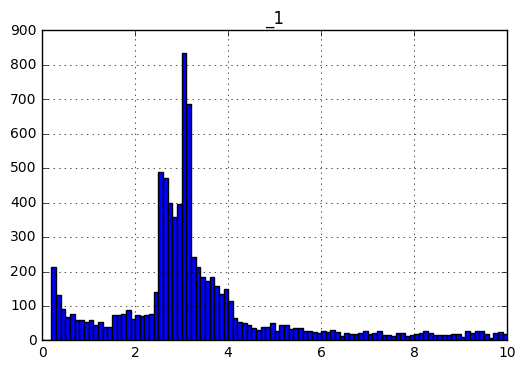

In [53]:
xxx = dimuon_masses.toPandas()
xxx.hist(bins=100, range=(0, 10))